### Importing

In [ ]:
import sys
sys.dont_write_bytecode = True

# uncomment load_ext line when you initially use the file, after you can comment to get rid of the warning that'll show up
# %load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_processing import prepData, transformData
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score # for finding r2 and MSE
from IPython.display import clear_output

path = '../data/bike.csv'
df = pd.read_csv(path, encoding_errors='ignore', parse_dates=['Date'], dayfirst=True)
pd.set_option('display.max_columns', None) # lets you scroll if your monitor isn't wide enough

df = prepData(df)
display(df)

cv = KFold(n_splits=5, shuffle=True, random_state=1) # for cross validation

,Rented Bike Count,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall (mm),Snowfall (mm),Spring,Summer,Autumn,Winter,Weekend
Date,,,,,,,,,,,,,
2017-12-01,9539,-2.454167,45.875000,1.537500,1870.750000,1.16,0.0,0.0,0,0,0,1,0
2017-12-02,8523,1.325000,61.958333,1.712500,1471.083333,1.12,0.0,0.0,0,0,0,1,1
2017-12-03,7222,4.875000,81.541667,1.612500,455.750000,0.69,4.0,0.0,0,0,0,1,1
2017-12-04,8729,-0.304167,52.500000,3.450000,1362.833333,1.17,0.1,0.0,0,0,0,1,0
2017-12-05,8307,-4.458333,36.416667,1.108333,1959.458333,0.64,0.0,0.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,17162,6.320833,70.500000,1.029167,475.000000,1.74,0.0,29.0,0,0,1,0,0
2018-11-27,16282,7.066667,68.000000,1.350000,405.291667,0.87,0.0,0.0,0,0,1,0,0
2018-11-28,16524,5.304167,25.791667,1.695833,1429.083333,1.86,0.0,0.0,0,0,1,0,0


In [2]:
y = df['Rented Bike Count'].to_numpy() # target value
X = df.drop('Rented Bike Count', axis=1) # taking out the target value

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

X_train, X_test, y_train, y_test = transformData(X_train, X_test, y_train, y_test)
X_train = pd.DataFrame(X_train, columns=X.columns) # so we can visualize everything nicely
X_test = pd.DataFrame(X_test, columns=X.columns) # so we can visualize everything nicely

## Applying Principal Component Analysis

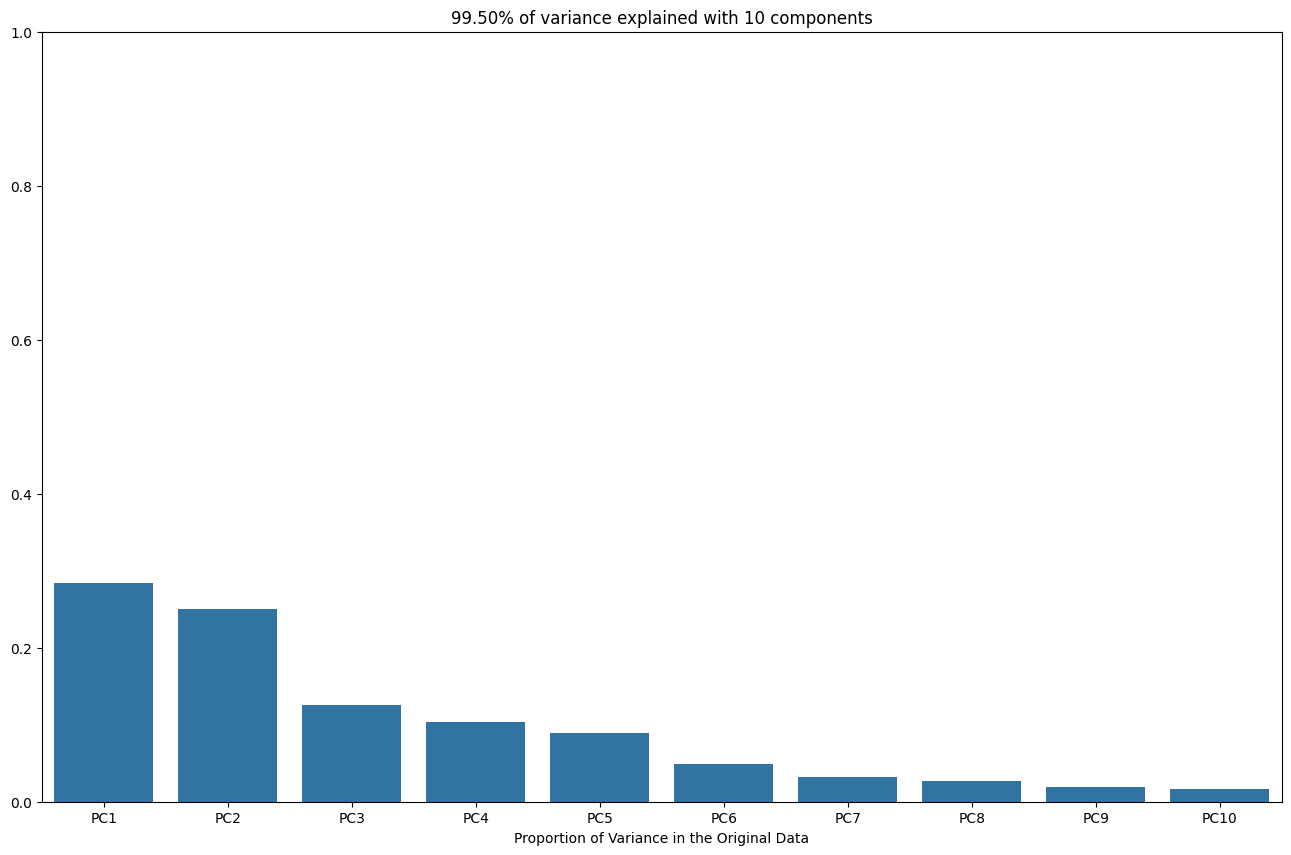

In [3]:
from sklearn.decomposition import PCA # dimension reduction

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
n_components = len(pca.components_)
plt.figure(figsize=(16,10))
sns.barplot(x=["PC" + str(i) for i in range(1, n_components + 1)], y=pca.explained_variance_ratio_)
plt.ylim(0,1)
plt.xlabel('Proportion of Variance in the Original Data')
plt.title(f'{sum(pca.explained_variance_ratio_)* 100:.2f}% of variance explained with {n_components} components')
plt.show()

Unfortunately, since PC1 and PC2 don't make up much of the variance, we have to use more components which make it impossible to visualize our data
<br>That being said, it's easier to work with 8000x11 than 8000x14

In [4]:
pca_xtrain = pd.DataFrame(X_train_pca,  columns=["PC" + str(i) for i in range(1, n_components + 1)])
pca_xtest = pd.DataFrame(X_test_pca,  columns=["PC" + str(i) for i in range(1, n_components + 1)])
display(pca_xtrain.head())
display(pca_xtest.head())
# xtrain and xtest now have their respective pca counterparts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.011597,-2.430742,1.167061,-0.319567,-0.085311,-0.544649,-0.044901,-0.179754,-0.134128,0.495757
1,0.423143,-1.910441,-0.238707,-0.686350,-0.128516,-0.341150,-0.530028,-0.227325,-0.085785,-0.521501
2,-0.406504,1.715030,0.009151,0.619129,0.329398,-0.812688,-0.273069,-0.301302,0.050763,0.409145
3,0.331294,0.882240,-0.387158,0.231198,-1.735486,0.884842,0.237471,-0.476976,-0.055786,0.156498
4,-1.079006,1.793997,-0.132108,0.462878,0.625260,-0.311008,-0.614609,0.617906,0.362965,-0.073732


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.595944,0.720182,-0.631680,-0.189262,-1.642679,0.078258,0.096796,-0.492033,0.389484,-0.307403
1,-2.132040,0.878220,-0.476228,-0.153135,0.251460,1.441460,-0.028824,-0.636447,0.268404,-0.331668
2,-1.620978,-0.562490,-0.197959,-0.514848,-0.100966,1.313735,0.198098,-0.621336,0.207382,0.212519
3,-0.596616,0.933281,-0.647523,-0.276359,0.704033,-0.170015,0.840621,-0.185634,-0.268964,0.207010
4,-1.412355,-0.088531,1.280212,0.765002,-0.010345,-0.740335,0.893916,0.097261,-0.234044,-0.414311


In [5]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.linear_model import ARDRegression, ElasticNet, ElasticNetCV, HuberRegressor, Lars, LarsCV, Lasso, LassoCV, LassoLarsCV, LassoLarsIC, LinearRegression
from sklearn.linear_model import QuantileRegressor, RANSACRegressor, Ridge, RidgeCV, SGDRegressor, BayesianRidge
from sklearn.linear_model import TheilSenRegressor, TweedieRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor,  HistGradientBoostingRegressor, RandomForestRegressor

In [6]:
all_model = { # random_state=1 for reproductability
    'DecisionTree' : DecisionTreeRegressor(random_state=1),
    'ExtraTree' : ExtraTreeRegressor(random_state=1),
    'KNeighbors' : KNeighborsRegressor(),
    'KernelRidge' : KernelRidge(),
    'LinearSVR' : LinearSVR(random_state=1),
    'SVR' : SVR(),
    'NuSVR' : NuSVR(),
    'ARDRegression' : ARDRegression(),
    'ElasticNet' : ElasticNet(random_state=1),
    'ElasticNetCV' : ElasticNetCV(random_state=1),
    'HuberRegressor' : HuberRegressor(),
    'Lars' : Lars(random_state=1),
    'LarsCV' : LarsCV(),
    'Lasso' : Lasso(random_state=1),
    'LassoCV' : LassoCV(random_state=1),
    'LassoLarsCV' : LassoLarsCV(),
    'LassoLarsIC' : LassoLarsIC(),
    'LinearRegression' : LinearRegression(),
    'QuantileRegressor' : QuantileRegressor(),
    'RANSACRegressor' : RANSACRegressor(random_state=1),
    'Ridge' : Ridge(random_state=1),
    'RidgeCV' : RidgeCV(),
    'SGDRegressor' : SGDRegressor(random_state=1),
    'BayesianRidge' : BayesianRidge(),
    'TheilSenRegressor' : TheilSenRegressor(random_state=1),
    'TweedieRegressor' : TweedieRegressor(),
    'ExtraTreesRegressor' : ExtraTreesRegressor(random_state=1),
    'GradientBoostingRegressor' : GradientBoostingRegressor(random_state=1),
    'HistGradientBoostingRegressor' : HistGradientBoostingRegressor(random_state=1),
    'RandomForestRegressor' : RandomForestRegressor(random_state=1),
    'XGBRegressor' : XGBRegressor()
    }

screening = [] # our output

for name, model in all_model.items():
    print(name) # for debugging

    reg = model.fit(pca_xtrain, y_train)

    train_pred = reg.predict(pca_xtrain)
    test_pred = reg.predict(pca_xtest)
    
    cv_r2_score = round(np.mean(cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2')), 2)
    r2_train = round(r2_score(y_train, train_pred), 2)
    r2_test = round(r2_score(y_test, test_pred), 2)
    mse_train = round(mean_squared_error(y_train, train_pred), 2)
    mse_test = round(mean_squared_error(y_test, test_pred), 2)
    rmse = np.sqrt(mse_test)
    screening.append([name, r2_test, r2_train, mse_test, mse_train, rmse, cv_r2_score])

# converting output to a dataframe and adding column names
screening_df = pd.DataFrame(screening, columns=('model', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'rmse', 'cv_r2_score'))

# makes it easier to find overfitting, should be positive
screening_df['r2_diff'] = screening_df['r2_test'] - screening_df['r2_train']

# makes it easier to find overfitting, should be negative
screening_df['mse_diff'] = screening_df['mse_test'] - screening_df['mse_train']

clear_output(True) # clean up output

DecisionTree
ExtraTree
KNeighbors
KernelRidge
LinearSVR
SVR
NuSVR
ARDRegression
ElasticNet
ElasticNetCV
HuberRegressor
Lars
LarsCV
Lasso
LassoCV
LassoLarsCV
LassoLarsIC
LinearRegression
QuantileRegressor
RANSACRegressor
Ridge
RidgeCV
SGDRegressor
BayesianRidge
TheilSenRegressor
TweedieRegressor
ExtraTreesRegressor
GradientBoostingRegressor
HistGradientBoostingRegressor
RandomForestRegressor
XGBRegressor


In [7]:
display(screening_df.loc[(screening_df['r2_diff']>=-0.15) & (screening_df['r2_test']>=0.70)].sort_values(['r2_diff', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,rmse,cv_r2_score,r2_diff,mse_diff
12,LarsCV,0.84,0.82,15709324.41,17556529.38,3963.499011,0.81,0.02,-1847204.97
15,LassoLarsCV,0.84,0.82,15709324.41,17556529.38,3963.499011,0.81,0.02,-1847204.97
13,Lasso,0.84,0.82,15712229.04,17555612.29,3963.865416,0.81,0.02,-1843383.25
11,Lars,0.84,0.82,15713052.09,17555582.32,3963.969234,0.81,0.02,-1842530.23
16,LassoLarsIC,0.84,0.82,15713052.09,17555582.32,3963.969234,0.81,0.02,-1842530.23
17,LinearRegression,0.84,0.82,15713052.09,17555582.32,3963.969234,0.81,0.02,-1842530.23
20,Ridge,0.84,0.82,15715898.75,17558266.11,3964.328285,0.81,0.02,-1842367.36
21,RidgeCV,0.84,0.82,15715898.75,17558266.11,3964.328285,0.81,0.02,-1842367.36
7,ARDRegression,0.84,0.82,15729148.57,17653987.55,3965.999063,0.81,0.02,-1924838.98
23,BayesianRidge,0.84,0.82,15732561.54,17574422.82,3966.429319,0.81,0.02,-1841861.28


### Results
While PCA will help models deal with high dimensions and multicollinearity, we'll lose the ability to draw insights from our predictions because we'll have transformed our features
<br>If we only cared about prediciting accurately then using PCA would be the better approach